<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу:" data-toc-modified-id="Вывод-по-разделу:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод по разделу:</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Описание проекта
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта**: 
- модель, предсказывающая возраст клиента по фотограии.
- `MAE` < 8

## Исследовательский анализ данных

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
ROOT_DIR = '/datasets/faces/'
LABEL_FILE = 'labels.csv'
DATA_DIR = 'final_files'
label_path =  os.path.join(ROOT_DIR, LABEL_FILE)
data_path = os.path.join(ROOT_DIR, DATA_DIR)

Датасет состоит из графических файлов - фотографий и csv файла с возрастом для персон на фото. Графические файлы будем загружать в модель с помощью генератора keras, метки загрузим сейчас с помощью pandas

In [3]:
df_labels = pd.read_csv(label_path)
print('Размер датасета:', df_labels.shape)
df_labels.info()
df_labels.describe()

Размер датасета: (7591, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


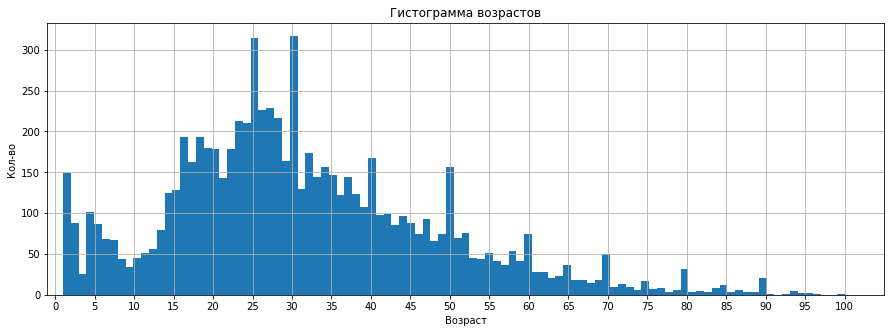

In [8]:
plt.figure(figsize=(15, 5))
plt.hist(x='real_age', data=df_labels, bins=100)
plt.xticks(range(0, 105, 5))
plt.xlim([-1, 105])
plt.title('Гистограмма возрастов')
plt.ylabel('Кол-во')
plt.xlabel('Возраст')
plt.grid()
plt.show()

Посмотрим несколько фотографий:

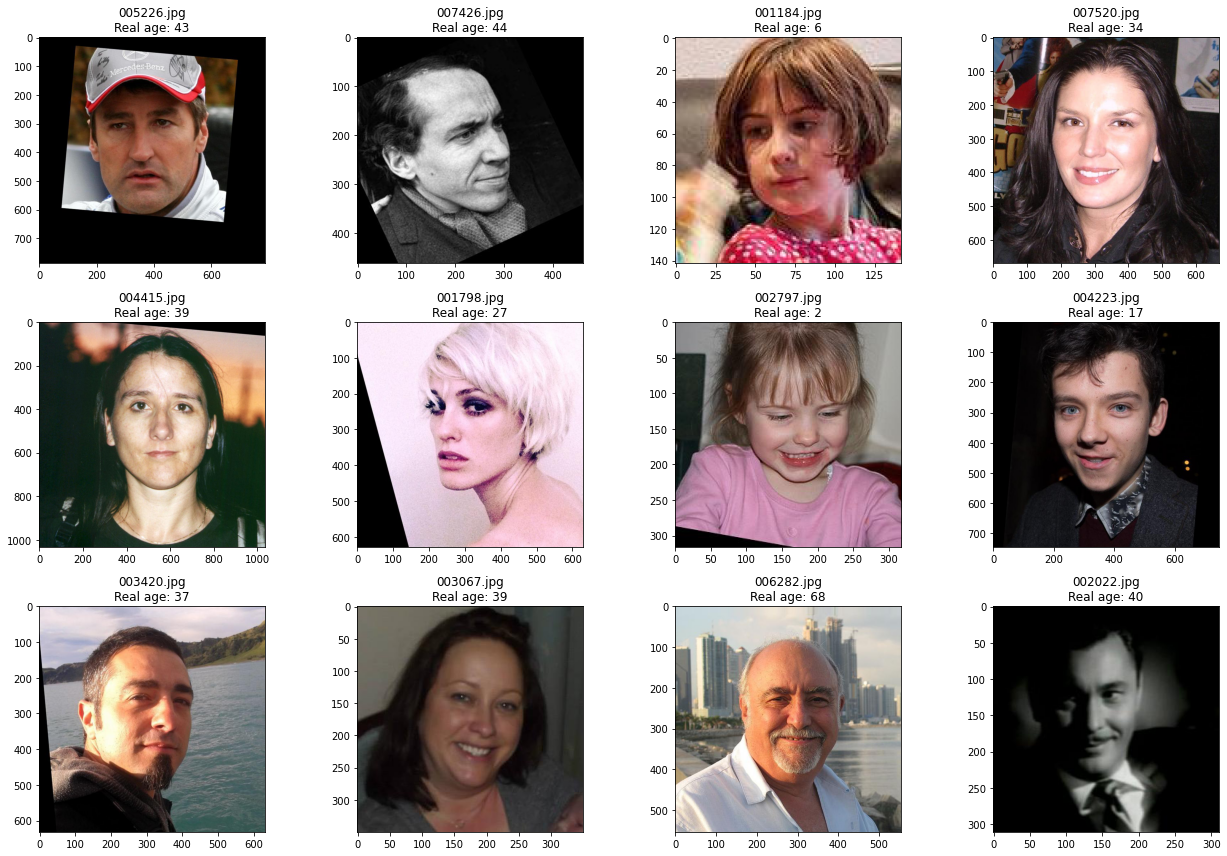

In [18]:
l_files = os.listdir(data_path)

fig, axs = plt.subplots(3, 4,  figsize=(18, 12))
for i in range(12):
    row = i // 4
    col = i % 4
    img = Image.open(os.path.join(data_path, l_files[i]))
    age = df_labels.loc[df_labels['file_name'] == l_files[i], 'real_age'].values[0]
    axs[row][col].imshow(img)
    axs[row][col].set_title(l_files[i] + f'\nReal age: {age}')
fig.tight_layout()    

### Вывод по разделу

Загрузили данные с истинным возрастом людей на фото: 1 год, 5, 16, 18, 25, 30, 40, 50 и т.д. лет - это важные этапы в жизни человека (судя по пикам на гистограмме).

По фотографиям видно что датасет подвергался аугментации - некторые фотографии повернут.

## Обучение модели

<p style="color:red">
Код в этом разделе запускается на сервере Яндекс.Практикум в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке</p>

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os
 
 
def load_train(path):
    train_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=train_labels,
            directory=os.path.join(path, 'final_files'),
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='training',            
            seed=100) 
 
    return train_gen_flow
 
 
def load_test(path):
    test_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=test_labels,
            directory=os.path.join(path, 'final_files'),
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='validation',            
            seed=100) 
 
    return test_gen_flow
 
 
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    #weights='imagenet', 
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, 
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)
 
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 70s - loss: 201.5986 - mae: 10.3628 - val_loss: 708.3369 - val_mae: 21.5519
Epoch 2/5
356/356 - 55s - loss: 67.7023 - mae: 6.2781 - val_loss: 138.5257 - val_mae: 9.0856
Epoch 3/5
356/356 - 55s - loss: 39.4145 - mae: 4.8591 - val_loss: 77.6960 - val_mae: 6.7091
Epoch 4/5
356/356 - 55s - loss: 26.5348 - mae: 3.9508 - val_loss: 85.0254 - val_mae: 6.9840
Epoch 5/5
356/356 - 55s - loss: 17.6235 - mae: 3.2540 - val_loss: 78.8667 - val_mae: 6.9303
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 78.8667 - mae: 6.9303
Test MAE: 6.9303

```

### Вывод по разделу:

По заданию MAE должно быть < 8. Модуль обучилась с MAE = 6.9303.

## Вывод

В качестве основы выбрана предварительно обученная модель ResNet с весами. Модель обучилась быстро, т.к. используемая основа - уже обученной модели.

Условие по целевой метрики выполнено.

При использованием callback API Keras можно было бы сохранить веса модели на этапе с val_mae: 6.7091 и mae: 4.8591 - на этом этапе модель еще не сильно переобучилась. Но так как сервера Яндекс (на которых обучалась модель) на протяжении двух суток постоянно испытывали нехватку ресурсов принято решение 
не усложнять модель и не обучать повторно.